In [39]:
import sys
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
sys.path.append('/workspace/wilson/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from evals import load_models
from utils import *
from group_data import *
from jaxtyping import Float
from typing import Union
from einops import repeat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
from llc import *
import gc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [3]:
#path = '/workspace/models/2024_08_02_02_17_18_S_5_'
#path = '/workspace/models/2024_08_03_00_04_30_Z_48_2_'
# path = '/workspace/models/2024_08_04_00_13_28_Z_48_2__twZ_48_'
#path = '/workspace/models/2024_08_03_21_29_50_Z_48_2__MLP4_512'
path = '/workspace/models/2024_08_05_18_31_53_S_5__times_A_5__Z_2__'
models, params = load_models(path, final=False)

100%|██████████| 1000/1000 [12:38<00:00,  1.32it/s]


In [5]:
dataset = GroupData(params)

Intersection size: 7920/14400 (0.55)
Added 7920 elements from intersection
Added 0 elements from group 0: S(5)
Added 0 elements from group 1: times(A(5),Z(2))
Train set size: 7920/14400 (0.55)


In [51]:
def plot_llc_epochs(models, dataset, instance, train_epochs=400, sgld_epochs=2000, eps=3e-3, beta=1e3, gamma=1., chains=1, cbatch_size=1, behavioral=True):
    gc.collect()
    t.cuda.empty_cache()
    model_traj = MLP3.stack([model[0] for model in models[:train_epochs]]).to(device)
    llc = get_llc(
        model_traj, dataset, eps=eps, beta=beta, gamma=gamma, chains=chains, cbatch_size=cbatch_size, behavioral=behavioral, epochs=sgld_epochs
    )
    loss_dict = test_loss(model_traj, dataset)
    fig, ax = plt.subplots()
    ax.plot(llc.tolist(), label='llc')
    ax2 = ax.twinx()
    ax2.plot((loss_dict['G0_acc'].detach().cpu().numpy() * 5000).tolist(), label='G0_acc', c='r', alpha=0.5)
    ax2.plot((loss_dict['G1_acc'].detach().cpu().numpy() * 5000).tolist(), label='G1_acc', c='g', alpha=0.5)
    plt.title(f'S5 v A(5)xZ(2) instance {instance:03}')
    plt.legend()
    plt.show()
    return llc, loss_dict

SGLD:   0%|          | 0/5 [00:00<?, ?it/s]

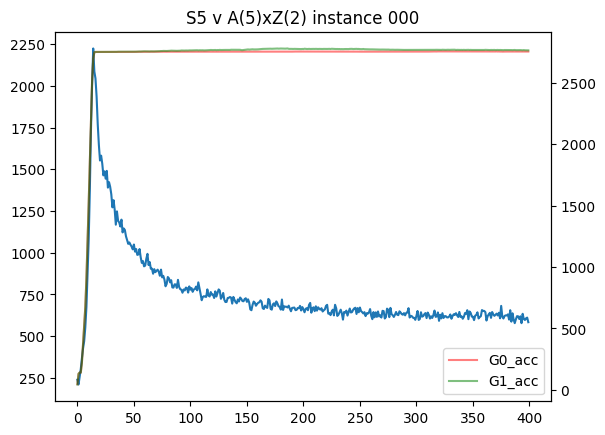

In [52]:
llc, loss_dict = plot_llc_epochs(models, dataset, 0, sgld_epochs=5)

In [42]:
f'{5:02}'

'05'

SGLD:   0%|          | 0/2000 [00:00<?, ?it/s]

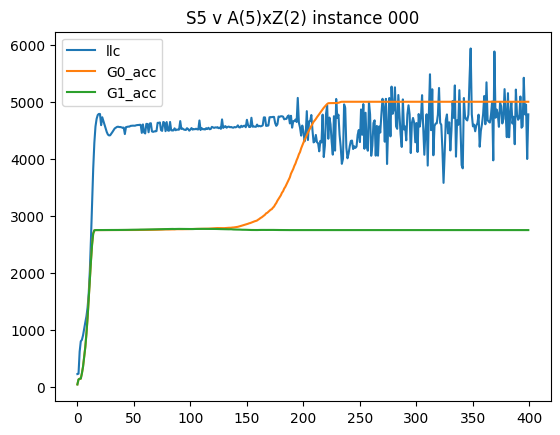

SGLD:   0%|          | 0/2000 [00:00<?, ?it/s]

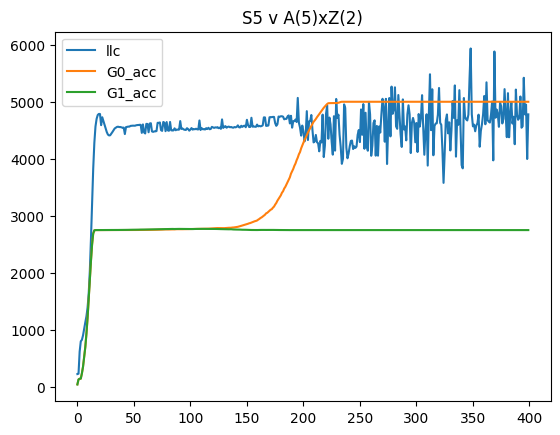

In [34]:
#del model_traj
import gc
gc.collect()
t.cuda.empty_cache()
model_traj = MLP3.stack([model[55] for model in models[:]])
model_traj = model_traj[:400].to(device)
bllc = get_llc(
    model_traj, dataset, eps=3e-3, beta=1e3, gamma=1., chains=1, cbatch_size=1, replacement=False, behavioral=True, epochs=2000, burnin=0.8
)
loss_dict = test_loss(model_traj, dataset)

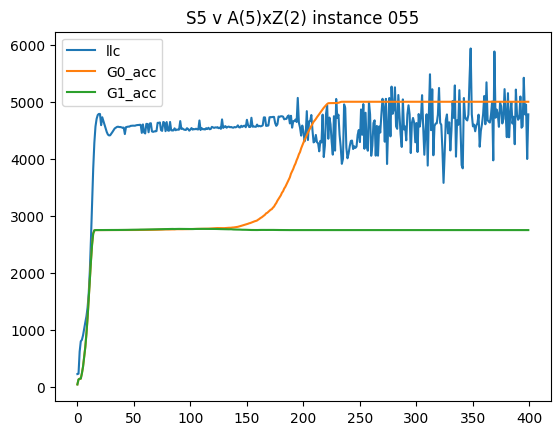

In [36]:
plt.plot(bllc.tolist(), label='llc')
plt.plot((loss_dict['G0_acc'].detach().cpu().numpy() * 5000).tolist(), label='G0_acc')
plt.plot((loss_dict['G1_acc'].detach().cpu().numpy() * 5000).tolist(), label='G1_acc')
plt.title('S5 v A(5)xZ(2) instance 055')
plt.legend()
plt.show()